In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from torch_geometric.loader import DataLoader
from CustomDataset import CustomDataset

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 'stix' is similar to Times New Roman
# If you want to use LaTeX to render all text (for more consistency)
# plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['xtick.major.width'] = 0.5  # Set x major tick width to 2 points
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Read ground truth and prediction

In [2]:
nt = 12

num_zones = 8

num_data = 200

# Ground truth
agg_Shedding_true = np.zeros((num_data, num_zones+1, nt))
agg_Shedding_pred = np.zeros((num_data, num_zones+1, nt))

# Read ground truth and prediction
for i in range(num_data):
    file_path  =f'../../res/IEEE_Case1354/model_evaluation/agg_Shedding/true/true_{i+1}.csv'
    ground_truth = pd.read_csv(file_path, header=None, index_col=None)
    agg_Shedding_true[i, :, :] = ground_truth.values.copy()

    file_path  =f'../../res/IEEE_Case1354/model_evaluation/agg_Shedding/pred/pred_{i+1}.csv'
    pred = pd.read_csv(file_path, header=None, index_col=None)
    agg_Shedding_pred[i, :, :] = pred.values.copy()

## One-on-one comparison

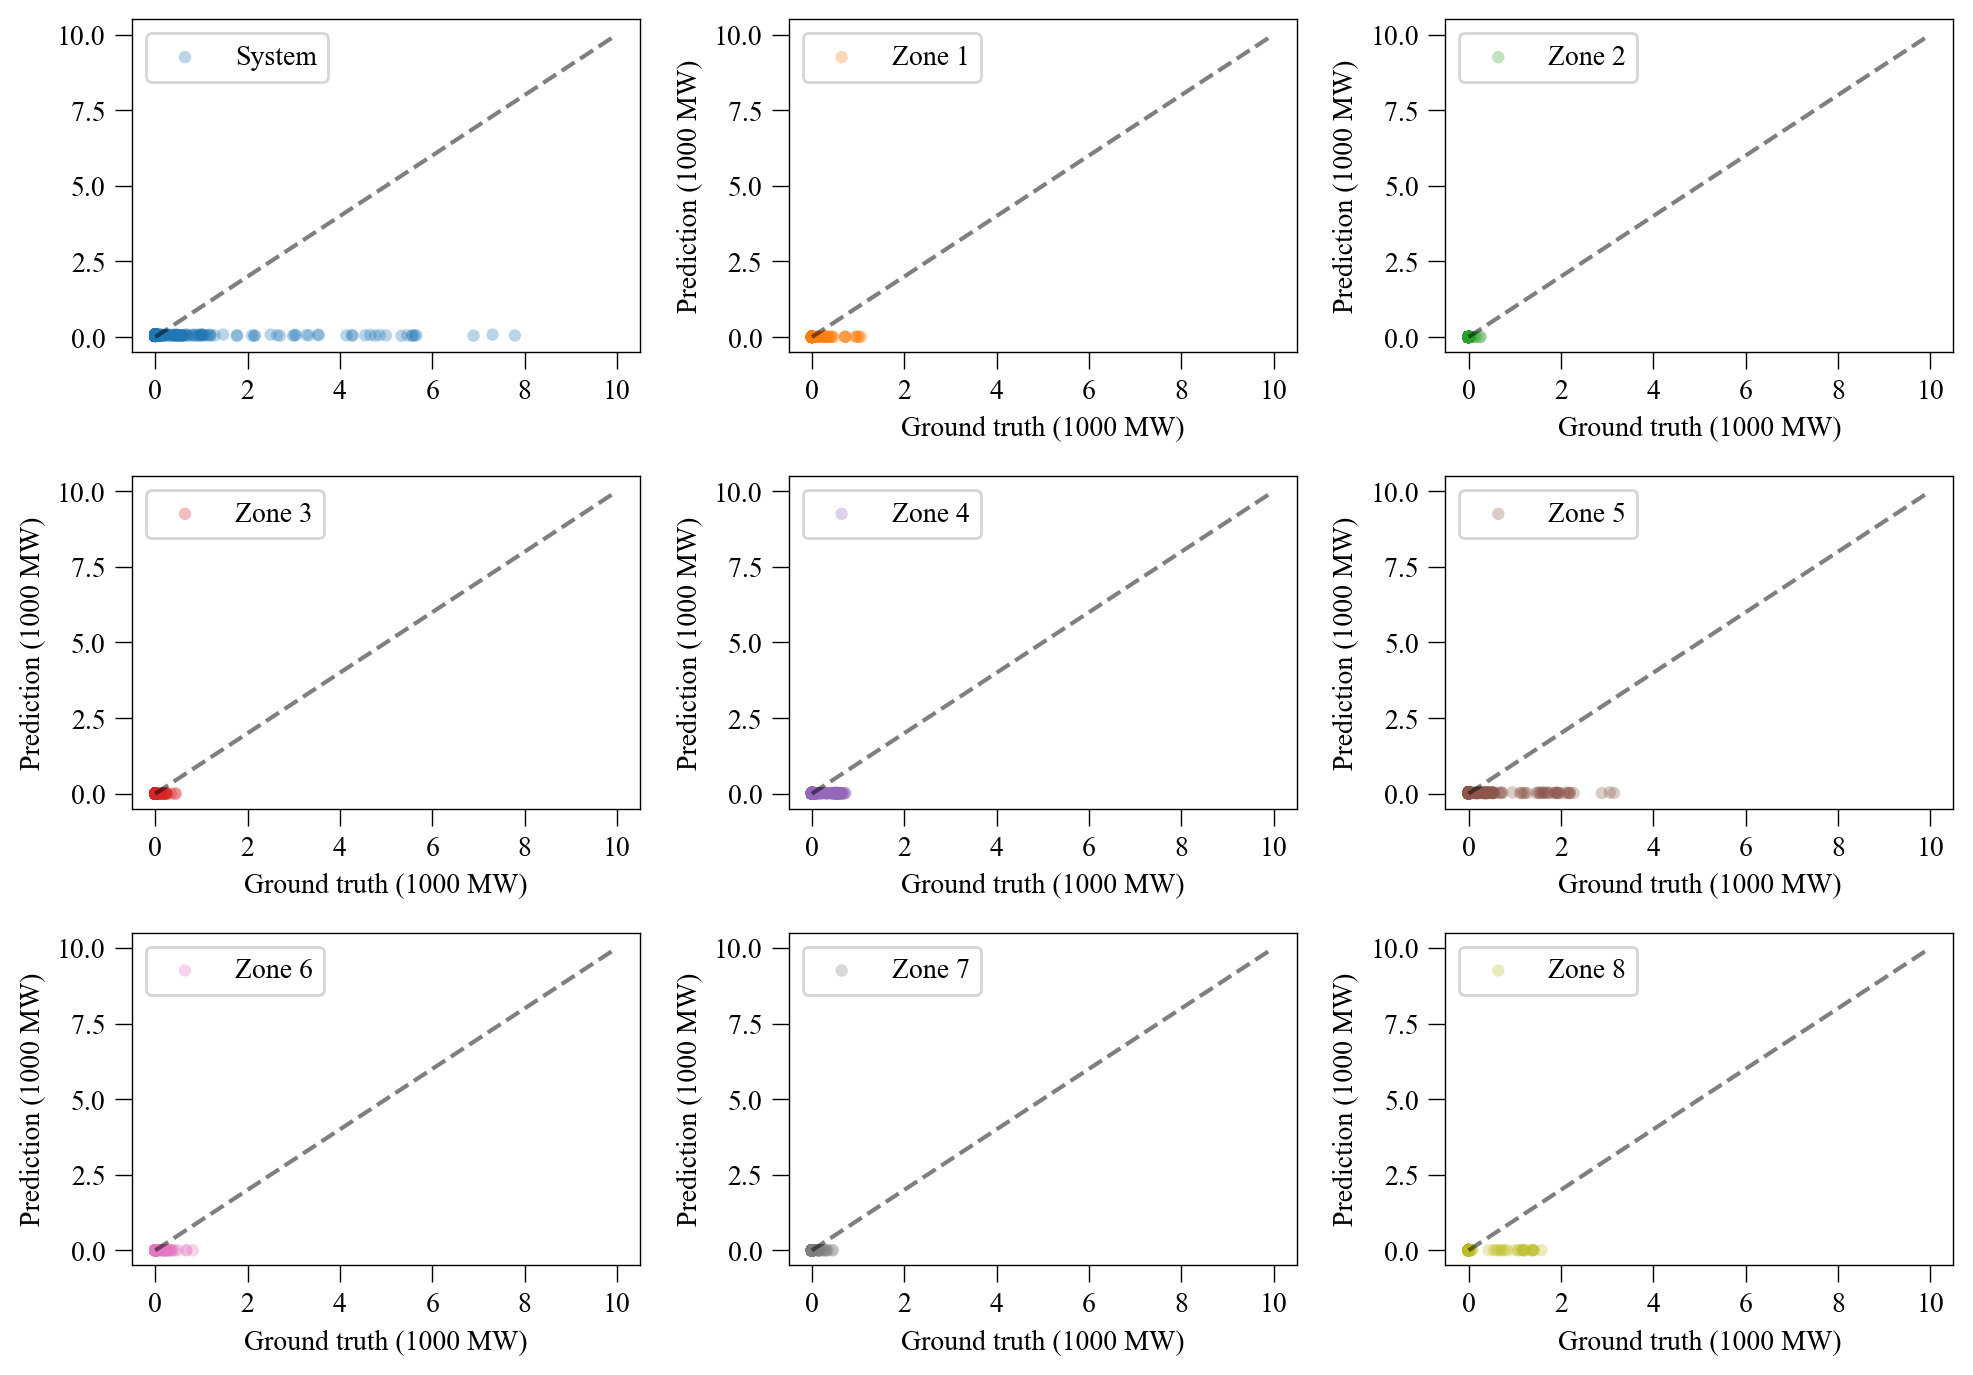

In [3]:
# System-level
fig = plt.figure(figsize=(10, 7))
x = np.linspace(0, 10, 100)
y = x

ax = fig.add_subplot(3, 3, 1)
ax.plot(x, y, 'k--', linewidth=1.5, alpha=0.5)
ax.scatter(agg_Shedding_true[:, 0, :].flatten()/1000, agg_Shedding_pred[:, 0, :].flatten()/1000, 
            s=20, c=colors[0], marker='o', edgecolors='none', alpha=0.3, label='System')
ax.legend(loc='upper left')

for i in range(1, num_zones+1):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(x, y, 'k--', linewidth=1.5, alpha=0.5)
    ax.scatter(agg_Shedding_true[:, i, :].flatten()/1000, agg_Shedding_pred[:, i, :].flatten()/1000, 
                s=20, c=colors[i], marker='o', edgecolors='none', alpha=0.3, label=f'Zone {i}')
    ax.set_xlabel('Ground truth (1000 MW)')
    ax.set_ylabel('Prediction (1000 MW)')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()
plt.close('all')

## Calculate MRE

In [4]:
##############################################################################################################
############################# Set threshold = 200 based on plot above ########################################
##############################################################################################################
rela_err = np.zeros(agg_Shedding_true.shape)   # Array to store relative error
MRE = np.zeros((num_zones+1, nt))       # Array to store mean relative error
indices = np.where(agg_Shedding_true > 200)     # Only consider the case where ground truth > 200
rela_err[indices] = (agg_Shedding_true[indices] - agg_Shedding_pred[indices]) / agg_Shedding_true[indices] * 100 # Relative error
MRE = np.mean(np.abs(rela_err), axis=0)    # Mean relative error

## Zone-level MRE

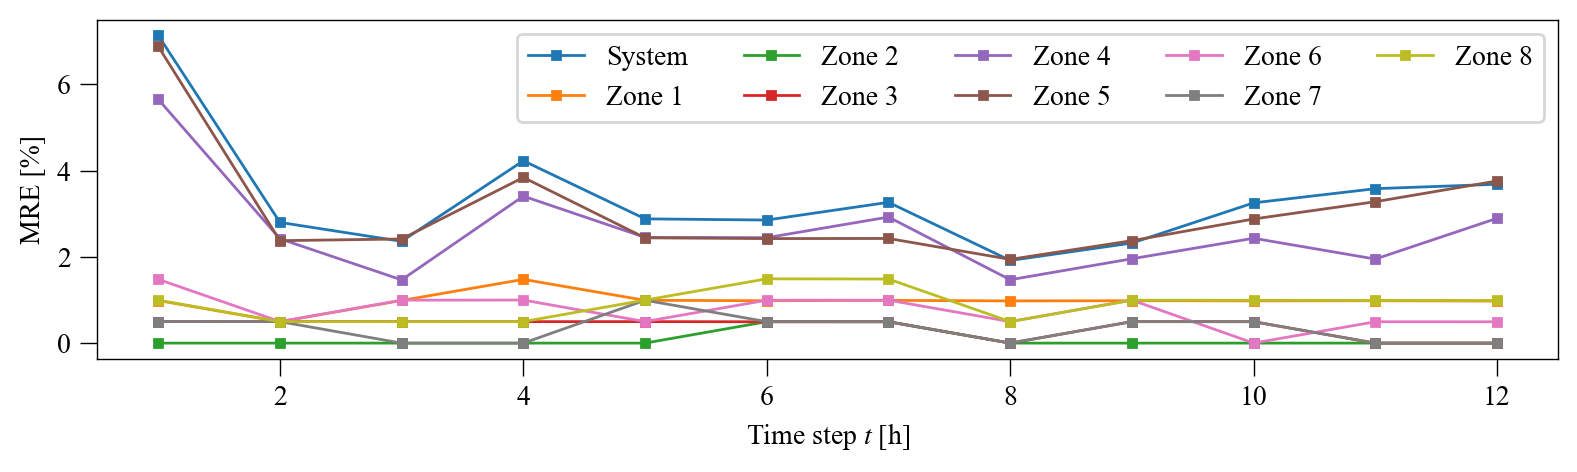

In [5]:
fig = plt.figure(figsize=(8, 2.5))
ax = fig.add_subplot(111)

# System
ax.plot(np.arange(1, 13), MRE[0, :], color=colors[0], linewidth=1, marker='s', markersize=3, label='System')
# Zones
for i in range(1, num_zones+1):
    ax.plot(np.arange(1, 13), MRE[i, :], color=colors[i],  linewidth=1, marker='s', markersize=3, label=f'Zone {i}')
    ax.set_xlabel('Time step $t$ [h]')
    ax.set_ylabel('MRE [%]')
    ax.set_xlim((0.5, 12.5))
    # ax.set_ylim(0, 6)
ax.legend(ncols=5)

plt.tight_layout()
plt.show()
# fig.savefig(f'../../res/IEEE_Case1354/model_evaluation/agg_PG_MRE.pdf', bbox_inches='tight')
plt.close('all')

In [9]:
# MRE table
columns = [f'T = {i}' for i in range(1, 13)]
MRE_table = pd.DataFrame(np.round(MRE, 3), columns=columns)
MRE_table

,T = 1,T = 2,T = 3,T = 4,T = 5,T = 6,T = 7,T = 8,T = 9,T = 10,T = 11,T = 12
0,7.133,2.798,2.360,4.227,2.880,2.853,3.264,1.916,2.320,3.251,3.580,3.682
1,0.987,0.498,0.989,1.477,0.992,0.983,0.991,0.979,0.982,0.979,0.982,0.975
2,0.000,0.000,0.000,0.000,0.000,0.497,0.497,0.000,0.000,0.000,0.000,0.000
3,0.499,0.499,0.498,0.497,0.498,0.495,0.496,0.000,0.498,0.497,0.000,0.000
4,5.651,2.419,1.465,3.407,2.451,2.444,2.922,1.468,1.955,2.431,1.948,2.893
5,6.877,2.375,2.414,3.840,2.440,2.423,2.426,1.941,2.374,2.877,3.278,3.758
6,1.479,0.499,0.996,0.998,0.499,0.995,0.996,0.498,0.997,0.000,0.495,0.495
7,0.500,0.498,0.000,0.000,0.994,0.497,0.494,0.000,0.497,0.496,0.000,0.000
8,0.996,0.498,0.499,0.499,0.997,1.490,1.485,0.498,0.995,0.993,0.988,0.989


In [11]:
tex_code = MRE_table.to_latex(index=False, escape=False)
print(tex_code)

\begin{tabular}{rrrrrrrrrrrr}
\toprule
T = 1 & T = 2 & T = 3 & T = 4 & T = 5 & T = 6 & T = 7 & T = 8 & T = 9 & T = 10 & T = 11 & T = 12 \\
\midrule
7.133000 & 2.798000 & 2.360000 & 4.227000 & 2.880000 & 2.853000 & 3.264000 & 1.916000 & 2.320000 & 3.251000 & 3.580000 & 3.682000 \\
0.987000 & 0.498000 & 0.989000 & 1.477000 & 0.992000 & 0.983000 & 0.991000 & 0.979000 & 0.982000 & 0.979000 & 0.982000 & 0.975000 \\
0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.497000 & 0.497000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
0.499000 & 0.499000 & 0.498000 & 0.497000 & 0.498000 & 0.495000 & 0.496000 & 0.000000 & 0.498000 & 0.497000 & 0.000000 & 0.000000 \\
5.651000 & 2.419000 & 1.465000 & 3.407000 & 2.451000 & 2.444000 & 2.922000 & 1.468000 & 1.955000 & 2.431000 & 1.948000 & 2.893000 \\
6.877000 & 2.375000 & 2.414000 & 3.840000 & 2.440000 & 2.423000 & 2.426000 & 1.941000 & 2.374000 & 2.877000 & 3.278000 & 3.758000 \\
1.479000 & 0.499000 & 0.996000 & 0.998000 & 0.499000 &